### Import libraries

In [1]:
import os.path
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm

### Functions

#### Data preprocessing

In [2]:
def data_preprocess(course_number):
    
    # the path for all courses
    base_path = r'../Sirius/Work'
    path = os.path.join(base_path, course_number)
    
    # loading all necessary course recordings
    user_element_progress = pd.read_csv(os.path.join(path, 'user_element_progress.csv'))
    course_module = pd.read_csv(os.path.join(path, 'course_module.csv'))
    user_module_progress = pd.read_csv(os.path.join(path, 'user_module_progress.csv'))
    course_element = pd.read_csv(os.path.join(path, 'course_element.csv'))
    course = pd.read_csv(os.path.join(path, 'course.csv'))
    
    # filtering the ordinary modules of first level
    ordinary_modules = course_module[(course_module.is_advanced == False) & (course_module.level == 1)]
    relevant_modules = user_module_progress[user_module_progress.course_module_id.isin(ordinary_modules.id)]

    # calculating the ordinary modules fraction of first level solved by students
    students = relevant_modules.groupby('user_id', as_index=False).aggregate({'is_achieved': lambda x: x.sum() / len(x)})\
    .rename(columns={'is_achieved': 'frac_achieved'})
    # dividing students on groups of achived (fraction equals 1.0) and not achieved the credit of a course 
    # - succeeded and unsucceeded
    succeeded_students = students[students.frac_achieved == 1]
    #unsucceeded_students = students[students.frac_achieved != 1]

    # filtering ordinary tasks
    ordinary_tasks = course_element[course_element.is_advanced == False]
    relevant_tasks = user_element_progress[user_element_progress.course_element_id.isin(ordinary_tasks.element_id)]

    # transforming date format
    relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
    relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
    course['date_start'] = pd.to_datetime(course['date_start'])
    course['close_date'] = pd.to_datetime(course['close_date'])
    
    # extracting registration and achieved weeks of each student
    course_start_week = course['date_start'].dt.isocalendar().week
    course_end_week = course['close_date'].dt.isocalendar().week
    relevant_tasks['registration_week'] = relevant_tasks['time_created'].dt.isocalendar().week
    relevant_tasks['registration_week'] -= course_start_week.iloc[0]
    relevant_tasks['achieved_week'] = relevant_tasks['time_achieved'].dt.isocalendar().week
    relevant_tasks['achieved_week'] = relevant_tasks[relevant_tasks['achieved_week'] <= course_end_week.iloc[0]]\
    ['achieved_week'].map(lambda x: x-course_start_week.iloc[0])

    # filtering tasks: 1) 'task' type, 2) credit achieved True, 3) solved (not carried from other cources)
    tasks = relevant_tasks[(relevant_tasks.course_element_type == 'task')\
                           & (relevant_tasks.is_achieved == True) & (relevant_tasks.achieve_reason == 'solved')\
                          & (relevant_tasks.achieved_week >= 0)].sort_values(by='achieved_week', ascending=True)
    
    # marking tasks of succeeded and unsucceeded students
    tasks['credit'] = np.where(tasks.user_id.isin(succeeded_students.user_id), 'yes', 'no')
    
    return tasks

#### Average tries number investigation

In [5]:
# tries number investigation

def tries_investigation(df, course_number, significance_level, total_courses):
    
    df = df[df.tries_count < 50] # filtering outliers: no more 50 tries

    def tries_and_students(df, course_number):
        
        # the average tries number of solving task by succeeded and unsucceeded students
        tries = df.groupby(['user_id', 'credit'], as_index=False).aggregate({'tries_count': np.mean})\
        .rename(columns={'tries_count': 'average_tries'})
    
        # plotting the distribution of average tries numbers for succeeded and unsucceeded students
        fig, ax = plt.subplots(2, 2, figsize=(13,8))
        sns.histplot(data=tries[tries.credit=='yes'], x='average_tries', binwidth=1, ax=ax[0,0])
        ax[0,0].set_title(label='The average tries number distribution of \n succeeded students')
        sns.histplot(data=tries[tries.credit=='no'], x='average_tries', binwidth=1, ax=ax[0,1])
        ax[0,1].set_title(label='The average tries number distribution of \n unsucceeded students')
        sns.histplot(data=tries[tries.credit=='yes'], x='average_tries', kde=True, stat='density', ax=ax[1,0])
        sns.histplot(data=tries[tries.credit=='no'], x='average_tries', kde=True, stat='density', ax=ax[1,1])
        fig.suptitle(course_number)
        plt.show()
        #plt.savefig('distributions.png', facecolor='w', edgecolor='w')
    
        # grouping students average tries by the weeks of a course 
    
        tries_groupedby_week = df[df.credit=='yes'].groupby('achieved_week', as_index=False)\
        .aggregate({'user_id': lambda x: x.nunique(), 'tries_count': np.mean})\
        .rename(columns={'user_id': 'succeeded_students', 'tries_count': 'succeeded_week_average_tries'})

        unsucceeded_tries_groupedby_week = df[df.credit=='no'].groupby('achieved_week', as_index=False)\
        .aggregate({'user_id': lambda x: x.nunique(), 'tries_count': np.mean})\
        .rename(columns={'user_id': 'unsucceeded_students', 'tries_count': 'unsucceeded_week_average_tries'})

        tries_groupedby_week = tries_groupedby_week.merge(unsucceeded_tries_groupedby_week, how = 'left', on = 'achieved_week')
    
        # plotting the weekly number of average tries and students
        fig, ax = plt.subplots(1, 2, figsize=(13,5))
        ax[0].plot(tries_groupedby_week['achieved_week'], tries_groupedby_week['succeeded_week_average_tries'], \
                   label="Succeeded_students", c='g')
        ax[0].plot(tries_groupedby_week['achieved_week'], tries_groupedby_week['unsucceeded_week_average_tries'],\
                   label="Unsucceeded_students", c='r')
        ax[0].set_xlabel('weeks')
        ax[0].set_ylabel('average_tries')
        ax[0].set_ylim([0, 7])
        ax[0].set_title('The weekly number of average tries')
        ax[0].grid(True)
        ax[0].legend()
        ax[1].plot(tries_groupedby_week['achieved_week'], tries_groupedby_week['succeeded_students'],\
                   label="Succeeded students", c='g')
        ax[1].plot(tries_groupedby_week['achieved_week'], tries_groupedby_week['unsucceeded_students'],\
                   label="Unsucceeded students", c='r')
        ax[1].set_xlabel('weeks')
        ax[1].set_ylabel('students')
        ax[1].set_title('The weekly number of students')
        ax[1].grid(True)
        ax[1].legend()
        fig.suptitle(course_number)
        plt.show()
        #plt.savefig('weekly_number.png', facecolor='w', edgecolor='w')
    
        #return tries_groupedby_week
    
    # the function of hypothesis testing via bootstrap method, source https://www.youtube.com/watch?v=-zps6hm0nX8

    def get_bootstrap(
        data_column_1, # first sample values 
        data_column_2, # second sample values 
        boot_it, # the number of bootstrap subsamples
        statistic, # statistic of interest
        bootstrap_conf_level # confidence level
    ):
        boot_len = max([len(data_column_1), len(data_column_2)])
        boot_data = []
        for i in tqdm(range(boot_it)): # exctracting subsamples
            samples_1 = data_column_1.sample(boot_len, 
                replace = True # returning parameter
            ).values
        
            samples_2 = data_column_2.sample(
                boot_len, # choosing the same sample size to save the variance 
                replace = True
            ).values
        
            boot_data.append(statistic(samples_1-samples_2)) 
        pd_boot_data = pd.DataFrame(boot_data)
        
        left_quant = (1 - bootstrap_conf_level)/2
        right_quant = 1 - (1 - bootstrap_conf_level) / 2
        quants = pd_boot_data.quantile([left_quant, right_quant])
        
        p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
        p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
        p_value = min(p_1, p_2) * 2
        average_diff = np.mean(boot_data)
       
        return quants, p_value, average_diff
    
    # hypothesis testing

    def tries_hypothesis_testing(df, significance_level, course_number, total_courses):
        
        tests_number = df.achieved_week.max() 
        alfa = significance_level/(tests_number + total_courses) # Bonferroni correction for multiple comparison
    
        quants_weeks = []
        p_value_weeks = []
        average_diff_weeks = []
    
        # grouping the weekly average tries numbers of each student
        for i in df.achieved_week.unique():
            weekly_tasks = df[df.achieved_week == i]
            week_tries = weekly_tasks.groupby(['user_id', 'credit'], as_index=False).aggregate({'tries_count': np.mean})\
            .rename(columns={'tries_count': 'week_average_tries'})
            
            succeeded_week_tries = week_tries[(week_tries.credit=='yes')]
            unsucceeded_week_tries = week_tries[(week_tries.credit=='no')]
        
            # testing hypothesis about the equality of average tries numbers of succeeded and unsucceeded students
            quants, p_value, average_diff = get_bootstrap(succeeded_week_tries.week_average_tries, \
                                                          unsucceeded_week_tries.week_average_tries, \
                                                          1000, np.mean, 1-alfa) 
    
            quants_weeks.append(quants)
            p_value_weeks.append(p_value) 
            average_diff_weeks.append(average_diff)
    
        # aggregating the results and cleaning
        results=pd.DataFrame({'quants' : quants_weeks, 'p_value' : p_value_weeks, 'average_diff' : average_diff_weeks})
        results['quants'] = results['quants'].map(lambda x: str(x)[str(x).find('0') + 1:])
        results['left_quant'] = results['quants'].map(lambda x: str(x)[-28:-19] if str(x).find('-') else str(x)[-27:-19])
        results['left_quant'] = results['left_quant']\
        .map(lambda x: str(x)[str(x).find(' ') + 1:] if str(x).find(' ') else str(x)).astype('float64') 
        results['right_quant'] = results['quants'].map(lambda x: str(x)[-9:] if str(x).find('-') else str(x)[-8:])
        results['right_quant'] = results['right_quant']\
        .map(lambda x: str(x)[str(x).find(' ') + 1:] if str(x).find(' ') else str(x)).astype('float64')
    
        # forming conclusions
        results['conf_interval'] = abs(results.left_quant - results.right_quant)
        results['significance_p_value'] = results.p_value<alfa
        results['significance_quants'] = ((results.left_quant>0)&(results.right_quant>0))\
        |((results.left_quant<0)&(results.right_quant<0))
    
        # plotting the average difference of average tries numbers of succeeded and unsucceeded students 
        # got by bootstrap method, and their statistical significance
        plt.plot(results.index, results.average_diff, c='b')
        #plt.ylim(top=3, bottom=-0.8)
        plt.xlabel(xlabel='weeks')
        plt.ylabel(ylabel='average_difference')
        plt.title(label=course_number)
        plt.grid(True)
        a1=results[(results.significance_p_value==True)|(results.significance_quants==True)]
        x1=a1.index
        y1=a1.average_diff
        plt.scatter(x1, y1, label="significant values", color='black', s=40, marker='X')
        plt.legend()
        plt.show()
        #plt.savefig('av_diff.png', facecolor='w', edgecolor='w')
        
        return results
    
    tries_and_students(df, course_number)
    results = tries_hypothesis_testing(df, significance_level, course_number, total_courses)
    
    return results

### Average tries number investigation

The research hypothesis: we believe that the more tries on average a student makes, the more difficult they take a course, and higher the risk of dropout.

The mathematical hypothesis: 
- null hypothesis: the average tries numbers of solving tasks equal between each other for students who will dropout a course and finish it successfully
- alternative hypothesis: a null hypothesis is wrong

#### 560 course

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

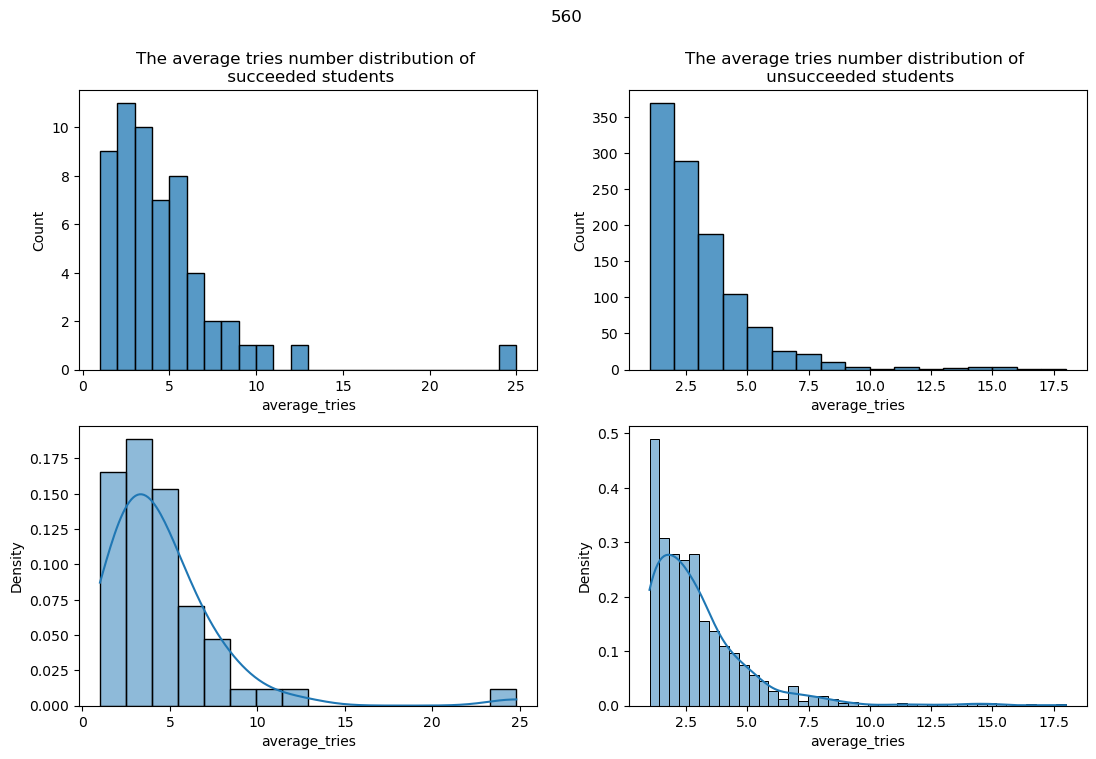

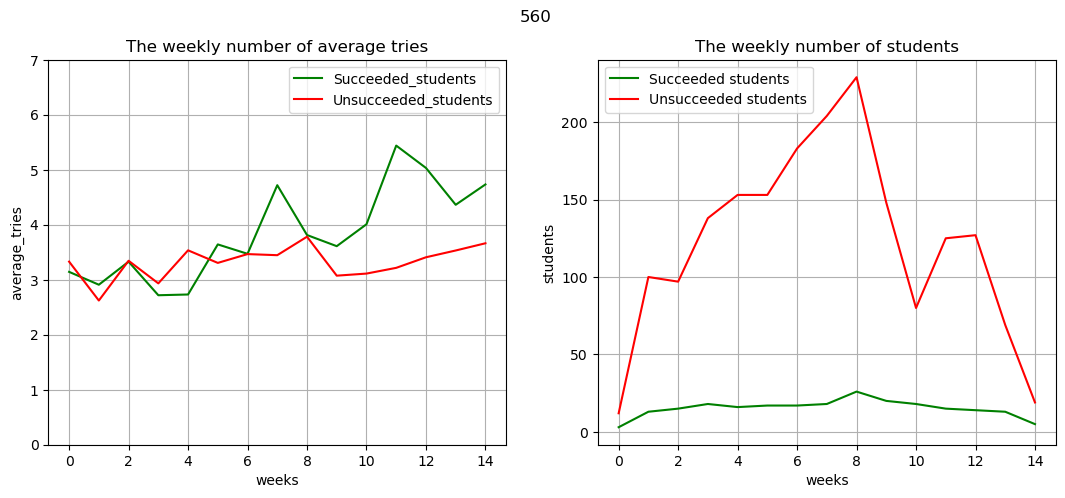

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

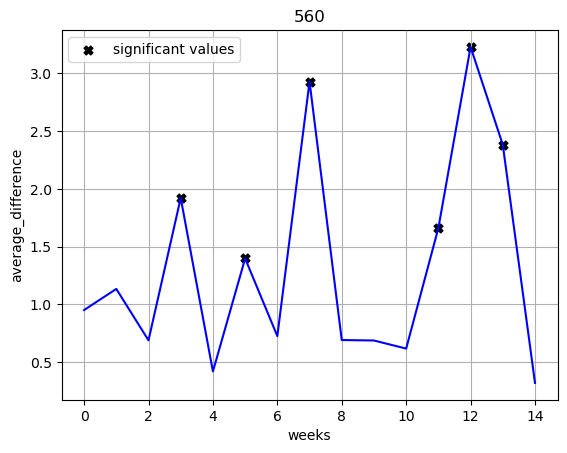

,quants,p_value,average_diff,left_quant,right_quant,conf_interval,significance_p_value,significance_quants
0,\n0.00125 -1.124266\n0.99875 2.711149,1.530565e-01,0.949345,-1.12426,2.711149,3.835409,False,False
1,\n0.00125 -0.001596\n0.99875 2.330326,4.997615e-03,1.132464,-0.00159,2.330326,2.331916,False,False
2,\n0.00125 -0.124308\n0.99875 1.559014,1.974856e-02,0.686908,-0.12430,1.559014,1.683314,False,False
3,\n0.00125 0.706563\n0.99875 3.225327,2.708052e-05,1.920819,0.70656,3.225327,2.518767,True,True
4,\n0.00125 -0.465934\n0.99875 1.298806,1.550128e-01,0.417022,-0.46593,1.298806,1.764736,False,False
5,\n0.00125 0.13633\n0.99875 2.71844,2.528712e-03,1.396323,0.13600,2.718440,2.582440,False,True
6,\n0.00125 -0.238867\n0.99875 1.864186,5.353616e-02,0.723682,-0.23886,1.864186,2.103046,False,False
7,\n0.00125 1.121992\n0.99875 5.133504,3.638360e-05,2.929157,1.12199,5.133504,4.011514,True,True
8,\n0.00125 -0.492399\n0.99875 1.649940,4.421638e-02,0.689402,-0.49239,1.649940,2.142330,False,False
9,\n0.00125 -0.316179\n0.99875 1.640320,2.057594e-02,0.685281,-0.31617,1.640320,1.956490,False,False


In [6]:
# distributions and the weekly number of average tries and students, hypothesis testing results

tries_investigation(data_preprocess('560'), '560', 0.05, 6)

#### 584 course

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

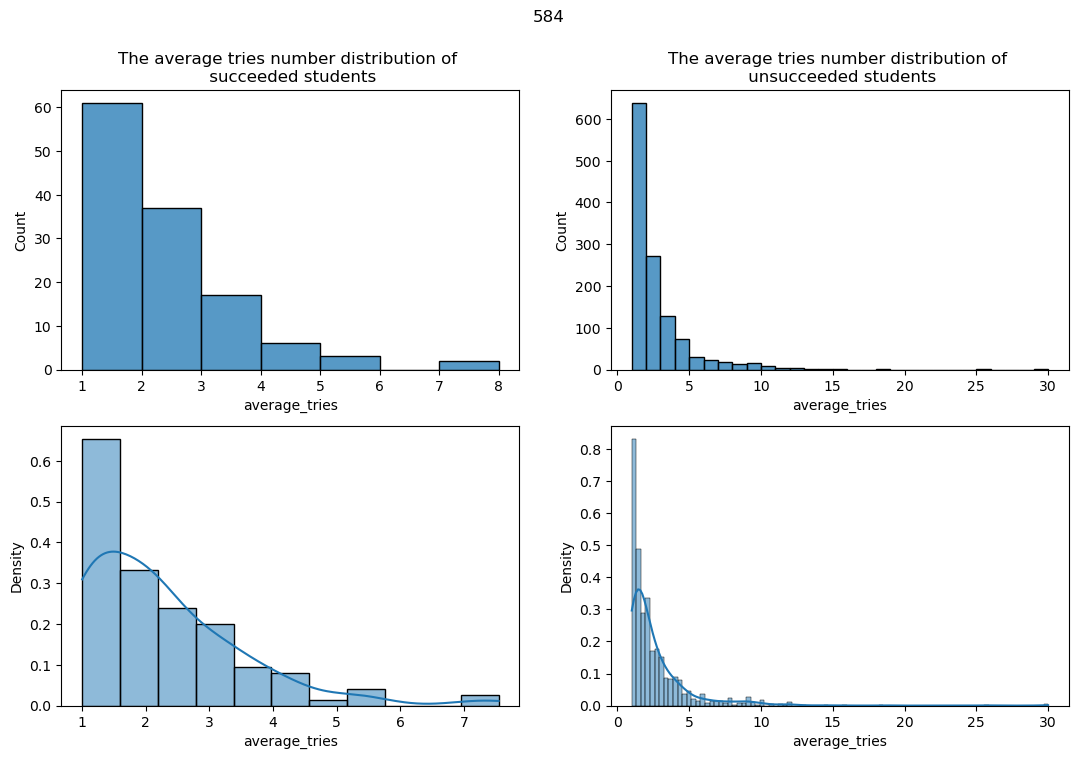

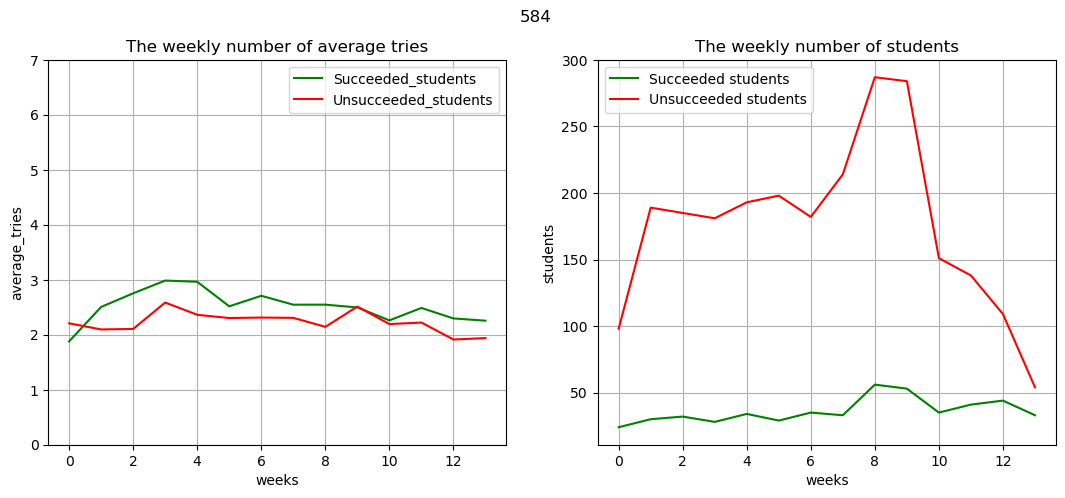

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

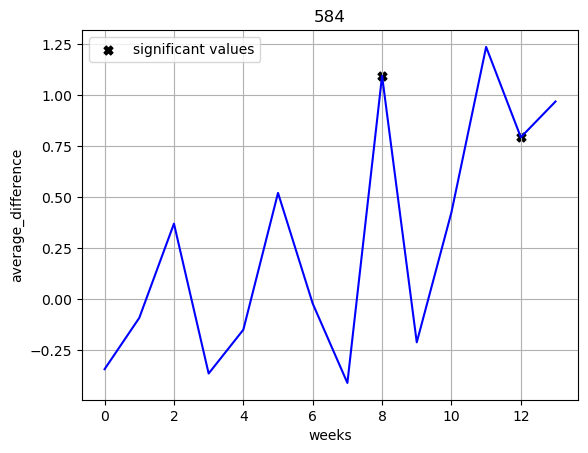

,quants,p_value,average_diff,left_quant,right_quant,conf_interval,significance_p_value,significance_quants
0,\n0.001316 -1.091482\n0.998684 0.519213,0.199694,-0.344778,-1.091482,0.519213,1.610695,False,False
1,\n0.001316 -0.837591\n0.998684 0.401644,0.639536,-0.092897,-0.837591,0.401644,1.239235,False,False
2,\n0.001316 -0.194985\n0.998684 0.873256,0.043197,0.369851,-0.194985,0.873256,1.068241,False,False
3,\n0.001316 -1.407875\n0.998684 0.718430,0.283604,-0.366115,-1.407875,0.718430,2.126305,False,False
4,\n0.001316 -0.945605\n0.998684 0.421672,0.506418,-0.151188,-0.945605,0.421672,1.367277,False,False
5,\n0.001316 -0.210371\n0.998684 1.353191,0.058655,0.520663,-0.210371,1.353191,1.563562,False,False
6,\n0.001316 -0.787189\n0.998684 0.770467,0.928561,-0.022477,-0.787189,0.770467,1.557656,False,False
7,\n0.001316 -0.966677\n0.998684 0.068642,0.035692,-0.412323,-0.966677,0.068642,1.035319,False,False
8,\n0.001316 0.170754\n0.998684 1.983478,0.000498,1.095590,0.170754,1.983478,1.812724,True,True
9,\n0.001316 -0.760309\n0.998684 0.316089,0.266573,-0.213032,-0.760309,0.316089,1.076398,False,False


In [7]:
# distributions and the weekly number of average tries and students, hypothesis testing results

tries_investigation(data_preprocess('584'), '584', 0.05, 6)

#### 587 course

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

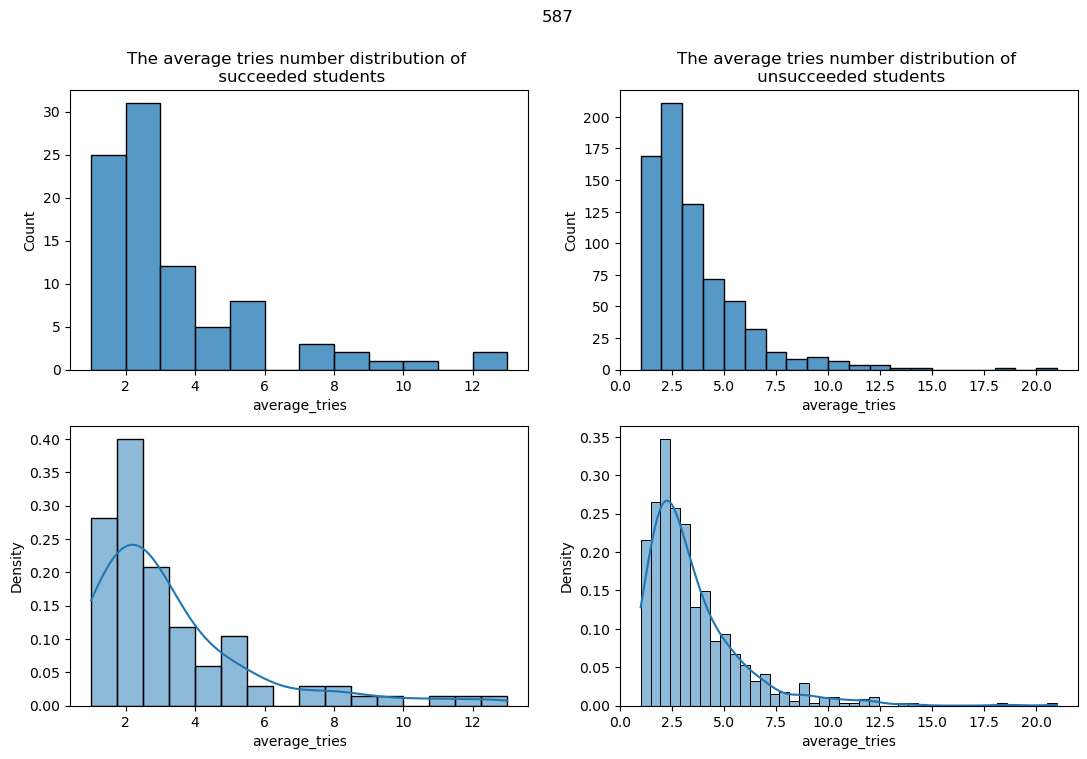

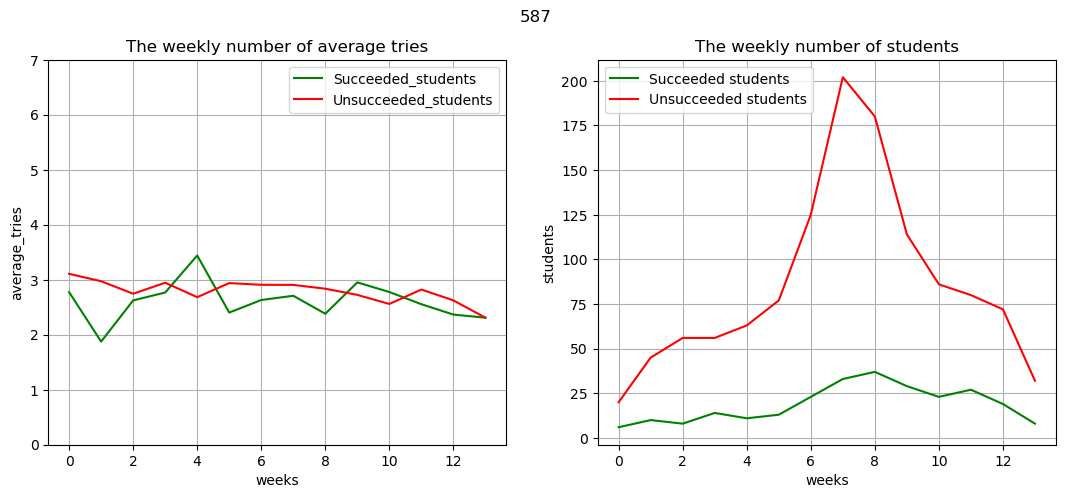

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

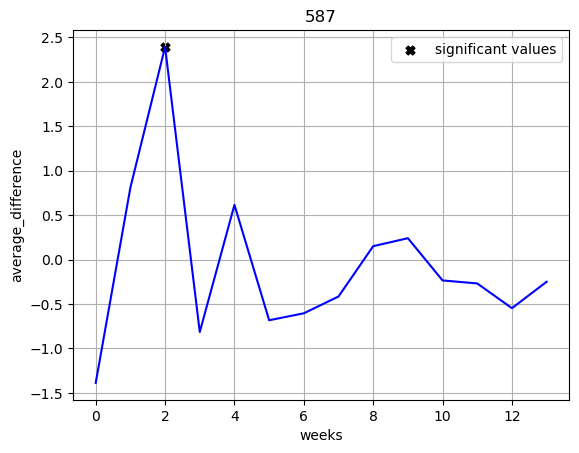

,quants,p_value,average_diff,left_quant,right_quant,conf_interval,significance_p_value,significance_quants
0,\n0.001316 -3.729531\n0.998684 1.430743,0.100884,-1.388165,-3.729531,1.430743,5.160274,False,False
1,\n0.001316 -1.183846\n0.998684 2.824463,0.251701,0.810247,-1.183846,2.824463,4.008309,False,False
2,\n0.001316 0.625467\n0.998684 4.794584,0.001253,2.393111,0.625467,4.794584,4.169117,True,True
3,\n0.001316 -2.601041\n0.998684 0.760027,0.171149,-0.815138,-2.601041,0.760027,3.361068,False,False
4,\n0.001316 -0.741093\n0.998684 1.889903,0.184164,0.616128,-0.741093,1.889903,2.630996,False,False
5,\n0.001316 -1.768163\n0.998684 0.044391,0.026396,-0.683036,-1.768163,0.044391,1.812554,False,False
6,\n0.001316 -1.468119\n0.998684 0.165442,0.040073,-0.604520,-1.468119,0.165442,1.633561,False,False
7,\n0.001316 -1.049101\n0.998684 0.164340,0.033449,-0.415711,-1.049101,0.164340,1.213441,False,False
8,\n0.001316 -0.928469\n0.998684 1.210390,0.681812,0.150752,-0.928469,1.210390,2.138859,False,False
9,\n0.001316 -1.256276\n0.998684 1.863384,0.629657,0.240532,-1.256276,1.863384,3.119660,False,False


In [9]:
# distributions and the weekly number of average tries and students, hypothesis testing results

tries_investigation(data_preprocess('587'), '587', 0.05, 6)

#### 613 course 

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

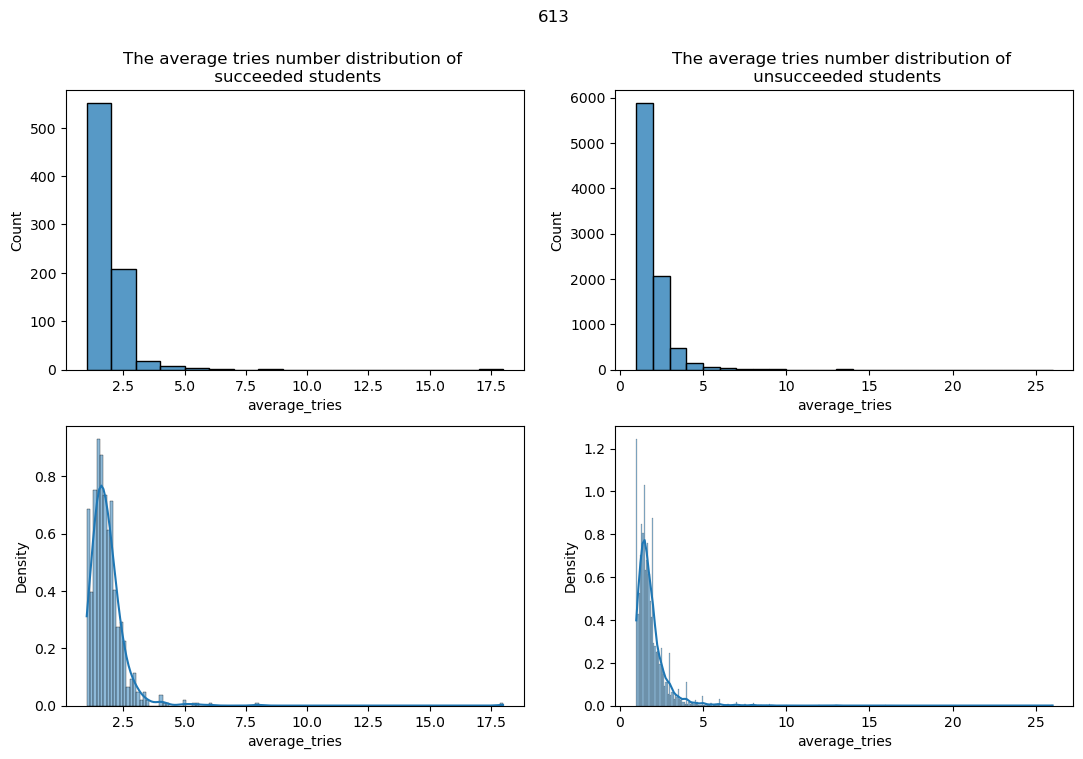

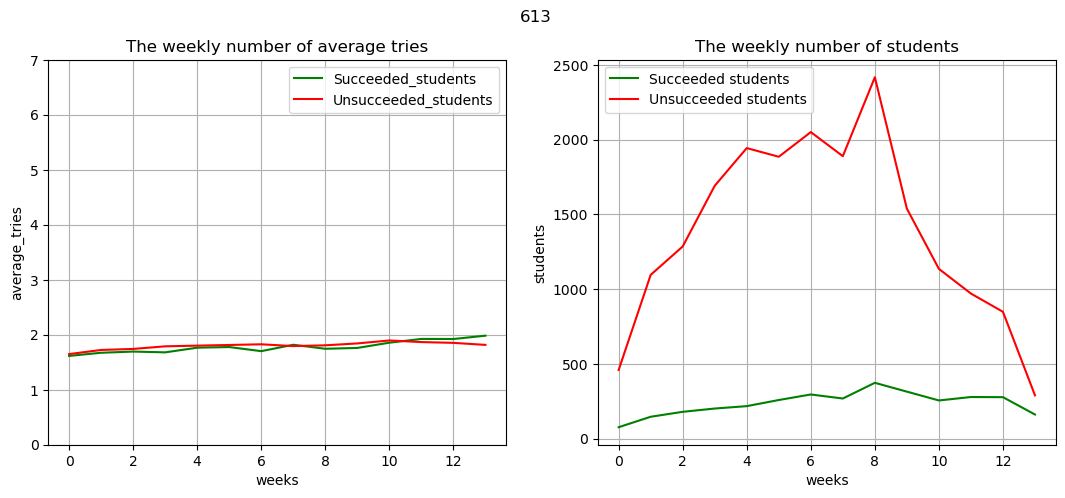

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

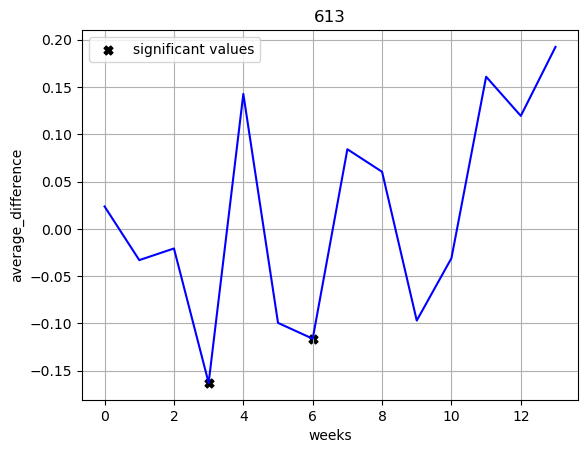

,quants,p_value,average_diff,left_quant,right_quant,conf_interval,significance_p_value,significance_quants
0,\n0.001316 -0.165218\n0.998684 0.172607,0.639191,0.023646,-0.165218,0.172607,0.337825,False,False
1,\n0.001316 -0.141594\n0.998684 0.082678,0.422111,-0.033050,-0.141594,0.082678,0.224272,False,False
2,\n0.001316 -0.170034\n0.998684 0.110217,0.657972,-0.020742,-0.170034,0.110217,0.280251,False,False
3,\n0.001316 -0.309167\n0.998684 -0.047984,0.000165,-0.162827,-0.309167,-0.047984,0.261183,True,True
4,\n0.001316 -0.072081\n0.998684 0.412882,0.082510,0.142592,-0.072081,0.412882,0.484963,False,False
5,\n0.001316 -0.233567\n0.998684 0.025610,0.021142,-0.099384,-0.233567,0.025610,0.259177,False,False
6,\n0.001316 -0.213576\n0.998684 -0.006082,0.001529,-0.116119,-0.213576,-0.006082,0.207494,True,True
7,\n0.001316 -0.091575\n0.998684 0.249280,0.171678,0.084131,-0.091575,0.249280,0.340855,False,False
8,\n0.001316 -0.060629\n0.998684 0.193685,0.172226,0.060286,-0.060629,0.193685,0.254314,False,False
9,\n0.001316 -0.294354\n0.998684 0.124676,0.184388,-0.096917,-0.294354,0.124676,0.419030,False,False


In [10]:
# distributions and the weekly number of average tries and students, hypothesis testing results

tries_investigation(data_preprocess('613'), '613', 0.05, 6)

#### 637 course

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

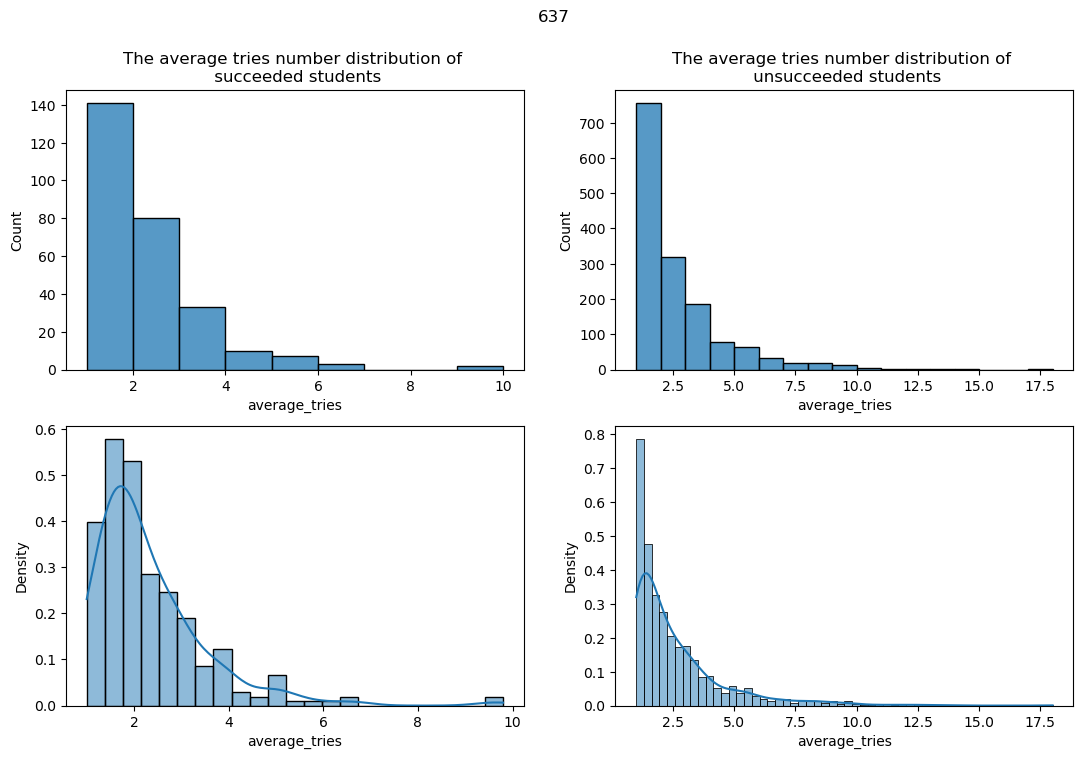

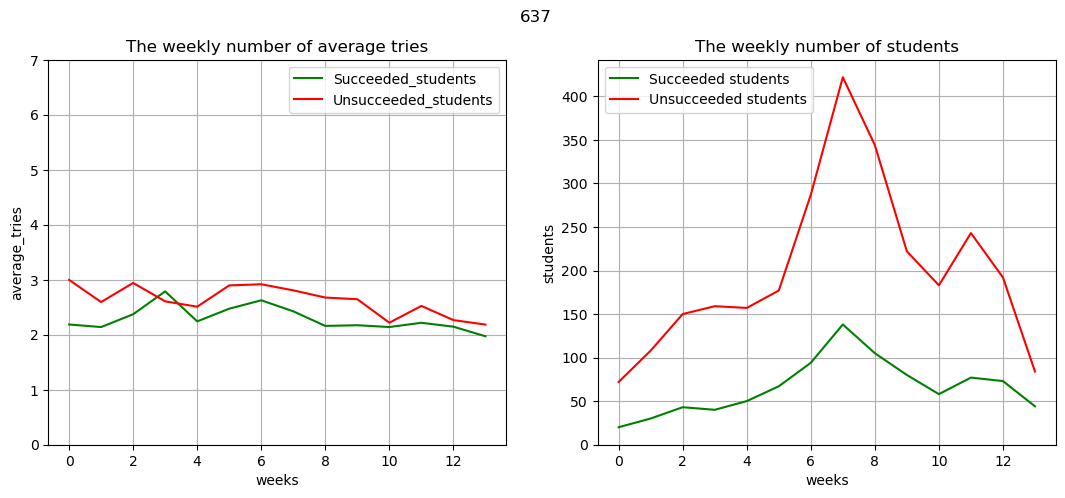

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

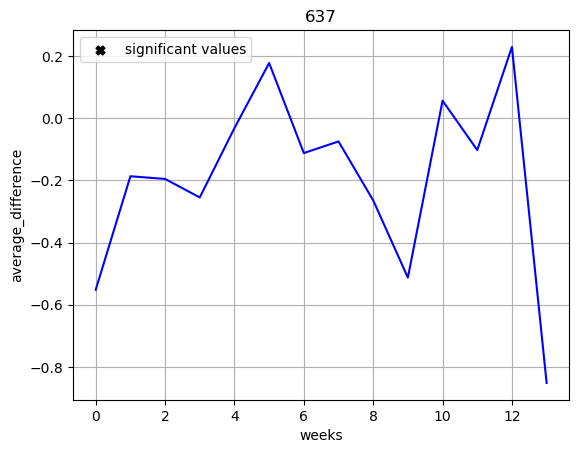

,quants,p_value,average_diff,left_quant,right_quant,conf_interval,significance_p_value,significance_quants
0,\n0.001316 -1.378125\n0.998684 0.207205,0.059201,-0.551691,-1.378125,0.207205,1.585330,False,False
1,\n0.001316 -1.182988\n0.998684 0.621055,0.522403,-0.186887,-1.182988,0.621055,1.804043,False,False
2,\n0.001316 -0.828154\n0.998684 0.485079,0.367423,-0.195536,-0.828154,0.485079,1.313233,False,False
3,\n0.001316 -1.038748\n0.998684 0.506004,0.295764,-0.255030,-1.038748,0.506004,1.544752,False,False
4,\n0.001316 -0.753258\n0.998684 0.531049,0.871924,-0.032010,-0.753258,0.531049,1.284307,False,False
5,\n0.001316 -0.813231\n0.998684 1.134790,0.544077,0.177075,-0.813231,1.134790,1.948021,False,False
6,\n0.001316 -0.610663\n0.998684 0.373364,0.508052,-0.112422,-0.610663,0.373364,0.984027,False,False
7,\n0.001316 -0.451218\n0.998684 0.259146,0.572184,-0.075003,-0.451218,0.259146,0.710364,False,False
8,\n0.001316 -0.817743\n0.998684 0.245909,0.152704,-0.264352,-0.817743,0.245909,1.063652,False,False
9,\n0.001316 -1.447773\n0.998684 0.127046,0.059262,-0.512696,-1.447773,0.127046,1.574819,False,False


In [11]:
# distributions and the weekly number of average tries and students, hypothesis testing results

tries_investigation(data_preprocess('637'), '637', 0.05, 6)

#### 638 course

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

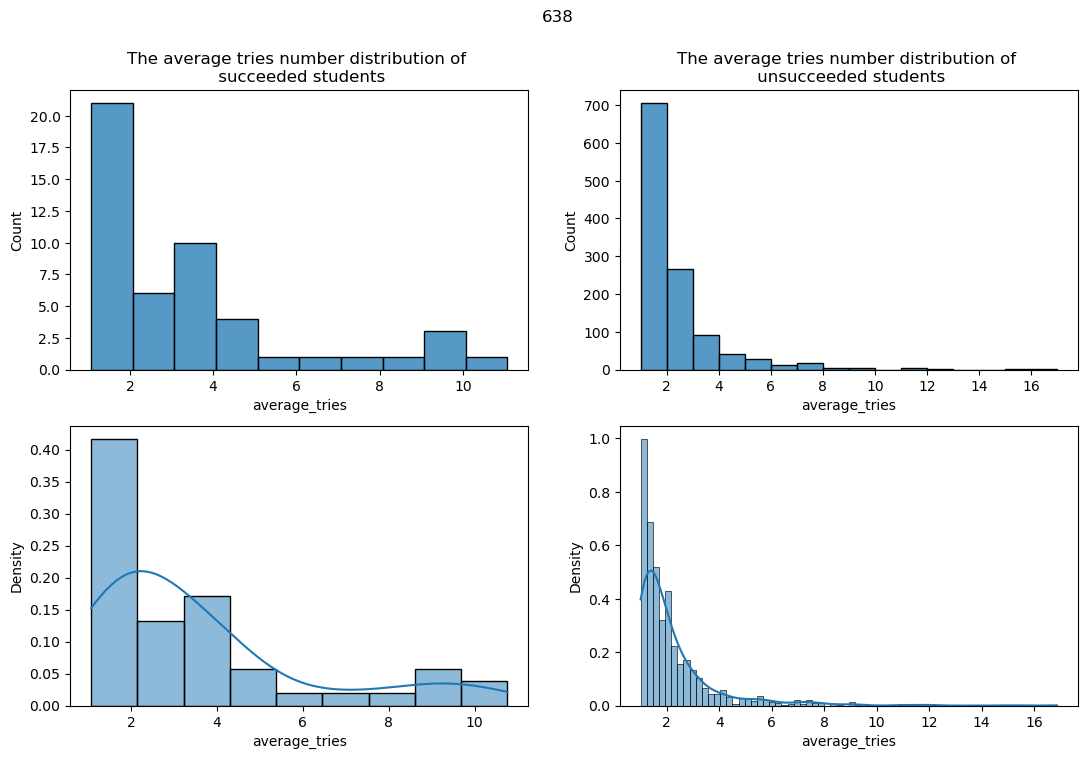

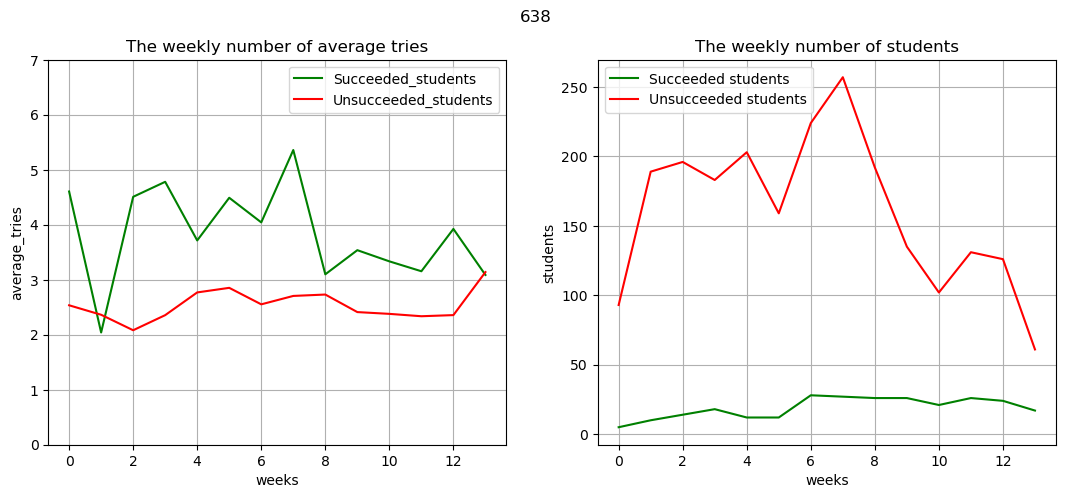

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

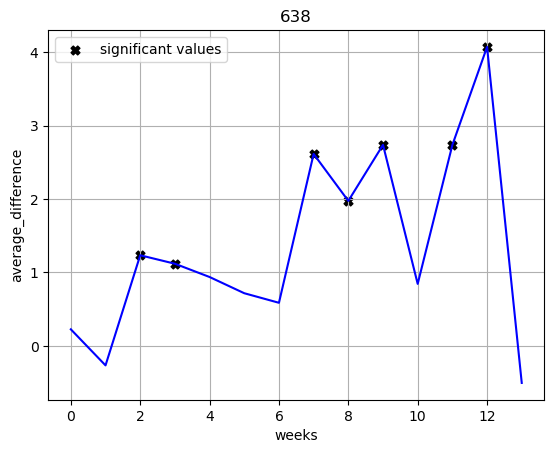

,quants,p_value,average_diff,left_quant,right_quant,conf_interval,significance_p_value,significance_quants
0,\n0.001316 -0.932199\n0.998684 1.172160,5.488340e-01,0.226341,-0.932199,1.172160,2.104359,False,False
1,\n0.001316 -0.710810\n0.998684 0.126495,5.645022e-02,-0.264468,-0.710810,0.126495,0.837305,False,False
2,\n0.001316 0.371722\n0.998684 1.943442,1.039530e-05,1.234559,0.371722,1.943442,1.571720,True,True
3,\n0.001316 0.293300\n0.998684 1.940188,3.426042e-05,1.119301,0.293300,1.940188,1.646888,True,True
4,\n0.001316 -0.11487\n0.998684 1.93256,9.890353e-03,0.938553,-0.114800,1.932560,2.047360,False,False
5,\n0.001316 -0.272027\n0.998684 1.544999,1.873875e-02,0.717805,-0.272027,1.544999,1.817026,False,False
6,\n0.001316 -0.188871\n0.998684 1.378829,1.431345e-02,0.587615,-0.188871,1.378829,1.567700,False,False
7,\n0.001316 1.589859\n0.998684 3.726916,1.524935e-12,2.613926,1.589859,3.726916,2.137057,True,True
8,\n0.001316 1.100590\n0.998684 2.778922,2.144535e-10,1.974629,1.100590,2.778922,1.678332,True,True
9,\n0.001316 1.120920\n0.998684 4.405982,1.896778e-06,2.737641,1.120920,4.405982,3.285062,True,True


In [12]:
# distributions and the weekly number of average tries and students, hypothesis testing results

tries_investigation(data_preprocess('638'), '638', 0.05, 6)

In [4]:
df = data_preprocess('560')        
    
for i in df.achieved_week.unique():
    weekly_tasks = df[df.achieved_week == i]
    week_tries = weekly_tasks.groupby(['user_id', 'credit'], as_index=False).aggregate({'tries_count': np.mean})\
    .rename(columns={'tries_count': 'week_average_tries'})
            
    succeeded_week_tries = week_tries[(week_tries.credit=='yes')]
    unsucceeded_week_tries = week_tries[(week_tries.credit=='no')]
        
    # testing hypothesis about the equality of average tries numbers of succeeded and unsucceeded students
    #quants, p_value, average_diff = get_bootstrap(succeeded_week_tries.week_average_tries, \
                                                  #unsucceeded_week_tries.week_average_tries, \
                                                  #1000, np.mean, 1-alfa) 
    print(week_tries)

C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_created'] = pd.to_datetime(relevant_tasks['time_created'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_tasks['time_achieved'] = pd.to_datetime(relevant_tasks['time_achieved'])
C:\Users\Kseniya\AppData\Local\Temp\ipykernel_9020\743499326.py:39: SettingWithCopyWarning: 
A value is trying to be set o

               user_id credit  week_average_tries
0   100119840511690114     no            2.500000
1   100119860511675466     no            2.000000
2   100119890511690049     no            2.000000
3   100120040112095996     no            5.750000
4   100120050110520754     no            2.000000
5   100120050111109080    yes            5.000000
6   100120050111425301     no            2.866667
7   100120050111672263     no            4.333333
8   100120050111901953     no            2.625000
9   100120060111430489     no            6.818182
10  100120060111686483    yes            5.000000
11  100120060111689103     no            2.333333
12  100120060111759188    yes            1.750000
13  100120060511690223     no            1.000000
14  100120080111186543     no            1.250000
                user_id credit  week_average_tries
0    100119700511690733    yes            4.433962
1    100119730111898463     no            3.250000
2    100119760112084260    yes            4.370